In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import math
import pyarrow.parquet as pq
import gc
import re
import seaborn
import matplotlib.pyplot as plt

from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import fbeta_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, hstack
from collections import Counter
from sklearn.metrics import log_loss
from tachis.sklearn.extraction import exoctet
from tachis.sklearn.xgb import save_xjs_model

%matplotlib inline


In [2]:
def replace_low_freq(df, col, min_count, replace_value=''):
    """
    Replaces cells in the dataframe for column :col: with :replace_value: where occurrences of values is less than
    :min_count:. Returns a copy of :param df:

    >>> df = replace_low_freq(df, 'partner_subid', 1000)
    :param df: the DataFrame
    :param col: the col to check for occurrences
    :param min_count: the minimum number of times each value in col needs to occur
    :return: a copy of df with values of col that occur less than min_count times replaced with replace_value
    """
    value_counts = df[col].value_counts()
    to_remove = value_counts[value_counts < min_count].index
    df = df.copy()
    df.loc[df[col].isin(to_remove), col] = replace_value
    return df

In [3]:
train = pq.ParquetDataset('marvel_data/balanced_train/').read().to_pandas()

In [4]:
# dev = pq.ParquetDataset('marvel_data/dev/').read().to_pandas()
test = pq.ParquetDataset('marvel_data/test/').read().to_pandas()

In [5]:
len(train[train.target == 1])

1342946

In [6]:
len(train[train.target == 0])

1342266

In [7]:
train['is_rt'] = np.zeros((train.shape[0], 1))

In [8]:
train.loc[pd.isna(train['rt_ts']), 'is_rt'] = False

In [9]:
train.loc[pd.notna(train['rt_ts']), 'is_rt'] = True

In [12]:
test['is_rt'] = np.zeros((test.shape[0], 1))
test.loc[pd.isna(test['rt_ts']), 'is_rt'] = False
test.loc[pd.notna(test['rt_ts']), 'is_rt'] = True

In [11]:
train

,uuid,advertiser_id,domain,country,region,city,browser,browser_family,device_name,source_id,...,adult,epoch,year,month,day,target,root_domain,tld,subid,is_rt
0,29cf1466a87011e79f180e6246b1924a,636,poll.surveyvoicesresearch.com,US,California,San Diego,op48,opera,generic web browser,1,...,False,1507058535,2017,10,3,1,surveyvoicesresearch.com,com,2204,False
1,304cbf9994ef11e7a9d50e7c0db46a68,636,www.onlinepromotionsusa.com,US,Illinois,Washington,cr60,chrome,generic web browser,150,...,False,1504914070,2017,9,8,0,onlinepromotionsusa.com,com,93008,False
2,14f2304d8ee911e7b92b0eda9b2f8f62,636,www.onlinepromotionsusa.com,US,Missouri,Wentzville,cr60,chrome,generic web browser,150,...,False,1504251739,2017,9,1,1,onlinepromotionsusa.com,com,93008,False
3,19c25bb9a34811e78bf71241fca26f88,636,www.onlinepromotionscenter.com,US,New Jersey,Parlin,sa11,safari,generic web browser,201,...,False,1506491574,2017,9,27,1,onlinepromotionscenter.com,com,5a01fca9-d552-45e9-a47c-f34d2a14e626,False
4,48c66e8661b811e781350ad033bde3ba,636,www.onlinepromotionsusa.com,US,Massachusetts,Jamaica Plain,sa9,safari,generic web browser,1,...,False,1499282978,2017,7,5,1,onlinepromotionsusa.com,com,2484,False
5,89af1f45999d11e7ba440a09b474eb3a,636,www.onlinepromotionsusa.com,US,New York,New York,ed15,microsoft edge,generic web browser,1,...,False,1505428756,2017,9,14,1,onlinepromotionsusa.com,com,2204,False
6,89f9020764c211e7abff0e14d77fd5ce,636,www.onlinepromotionsusa.com,US,None,None,ff48,firefox,generic web browser,173,...,False,1499617239,2017,7,9,1,onlinepromotionsusa.com,com,669206,False
7,632e42d994ef11e7b9a10e740db94366,636,www.onlinepromotionsusa.com,US,Illinois,Washington,cr60,chrome,generic web browser,151,...,False,1504914155,2017,9,8,1,onlinepromotionsusa.com,com,93008,False
8,8d950247631711e791900a49a2e7471a,636,www.amarktflow.com,US,New York,Brockport,cr59,chrome,generic web browser,1,...,False,1499433847,2017,7,7,1,amarktflow.com,com,2204,False
9,b0211510626011e7b00912332a32753a,636,www.amarktflow.com,US,North Carolina,Concord,ff9,firefox,generic web browser,1,...,False,1499355310,2017,7,6,1,amarktflow.com,com,2450,False


In [13]:
train.dtypes

uuid               object
advertiser_id       int64
domain             object
country            object
region             object
city               object
browser            object
browser_family     object
device_name        object
source_id          object
partner_id        float64
partner_subid      object
product_id        float64
ip                 object
bid_amount        float64
net_bid           float64
campaign_id         int64
time               object
ttt                object
rt_ts             float64
device_type        object
adult                bool
epoch               int64
year                int32
month               int32
day                 int32
target              int32
root_domain        object
tld                object
subid              object
dtype: object

In [13]:
train['time'] = pd.to_datetime(train.time)

In [14]:
import datetime as datetime

In [16]:
train.sort_values('epoch')

,uuid,advertiser_id,domain,country,region,city,browser,browser_family,device_name,source_id,...,device_type,adult,epoch,year,month,day,target,root_domain,tld,subid
416836,3b57bfdd5df011e79db0127fbe7c3592,8961,ocsp.verisign.com,US,Florida,Lake Worth,ie11,ie,generic web browser,4,...,desktop,False,1498867206,2017,7,1,0,verisign.com,com,1351
2175377,3a634df75df011e7ba960a49a2e7471a,20404,murniqq.org,ID,Jakarta,Jakarta,cr59,chrome,generic web browser,1,...,desktop,False,1498867216,2017,7,1,1,murniqq.org,org,2450
165528,43a4fdfe5df011e794300e86f49701ac,19387,teenpornstorage.biz,NL,South Holland,Schiedam,other,yandex.browser,generic web browser,136,...,desktop,True,1498867217,2017,7,1,0,teenpornstorage.biz,biz,
2468929,3e1224ed5df011e7af8c0acae78c53d2,21810,www.tricae.com.br,BR,Sao Paulo,Sao Paulo,cr59,chrome,generic web browser,131,...,desktop,False,1498867217,2017,7,1,1,tricae.com.br,com.br,51557_4374_
2468927,3e1224ed5df011e7af8c0acae78c53d2,21810,www.tricae.com.br,BR,Sao Paulo,Sao Paulo,cr59,chrome,generic web browser,131,...,desktop,False,1498867217,2017,7,1,1,tricae.com.br,com.br,51557_4374_
2468928,3e1224ed5df011e7af8c0acae78c53d2,21810,www.tricae.com.br,BR,Sao Paulo,Sao Paulo,cr59,chrome,generic web browser,131,...,desktop,False,1498867217,2017,7,1,1,tricae.com.br,com.br,51557_4374_
422251,486a27005df011e7935b1294e5a10f80,4543,www.asos.fr,BE,Liege Province,Verviers,cr58,chrome,generic web browser,28,...,desktop,False,1498867225,2017,7,1,1,asos.fr,fr,5073fe77845a7115a982b662c525021c
460635,603bdeb75df011e7a62f12954ecd8c60,8040,www.supermechs.com,DE,None,None,cr59,chrome,generic web browser,150,...,desktop,False,1498867267,2017,7,1,0,supermechs.com,com,72169
2401125,78a850055df011e7af8e0e38ca6a29fe,19387,m.vporn.com,DE,Lower Saxony,Hanover,cr58,chrome mobile,generic android 7.0,136,...,mobile,True,1498867305,2017,7,1,0,vporn.com,com,
2208429,772b25785df011e7a8660ad033bde3ba,18531,lp.onlinecasinoreports.com,GB,Lancashire,Burnley,ff53,firefox,generic web browser,1,...,desktop,False,1498867316,2017,7,1,0,onlinecasinoreports.com,com,2204


In [15]:
features = ['domain', 'root_domain', 'country', 'region', 'city', 'browser', 'browser_family', 'device_name', 'source_id', 'subid', 'device_type', 'adult', 'is_rt', 'tld']

In [16]:
dev, test = train_test_split(test, test_size=.5, shuffle=True, stratify=test.target, random_state=12398)

In [17]:
dev.shape, test.shape

((235176, 31), (235176, 31))

In [18]:
for feature in features:
    train = replace_low_freq(train, feature, 30)

In [19]:
ua_splitter = re.compile(r'\W+')
subid_splitter = re.compile(r'[^a-zA-Z0-9]')
def get_features(df, features):
    for row in df.itertuples(index=False):
        d = {}
        for feature in features:
            val = getattr(row, feature)
            if val is None or val == '' or isinstance(val, float) and math.isnan(val):
                continue
            if feature == 'ua':
                parts = ua_splitter.split(val)
                for part in parts:
                    if part:
                        hashName = f'{feature}={part}'
                        d[hashName] = 1
                continue
            if feature == 'subid':
                parts = subid_splitter.split(val)
                for part in parts:
                    if part:
                        hashName = f'{feature}={part}'
                        d[hashName] = 1
                continue                
            hashName = f'{feature}={val}'
            d[hashName] = 1
        yield d
        

In [20]:
hasher = FeatureHasher(non_negative=True, alternate_sign=False)

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


In [21]:
exoc_train = exoctet(train)

In [22]:
exoc_dev = exoctet(dev)

In [23]:
exoc_test = exoctet(test)

In [24]:
y_train = train['target'].values.astype(np.bool)

In [25]:
y_dev = dev['target'].values.astype(np.bool)

In [26]:
y_test = test['target'].values.astype(np.bool)

In [27]:
test = test.drop('target', axis=1)

In [28]:
train = train.drop('target', axis=1)

In [29]:
dev = dev.drop('target', axis=1)

In [30]:
hashed_train = hasher.transform(get_features(train, features))

In [31]:
hashed_dev = hasher.transform(get_features(dev, features))

In [32]:
hashed_test = hasher.transform(get_features(test, features))

In [33]:
stacked_train = hstack((hashed_train, exoc_train))

In [34]:
stacked_dev = hstack((hashed_dev, exoc_dev))

In [35]:
stacked_test = hstack((hashed_test, exoc_test))

In [36]:
dtrain = xgb.DMatrix(stacked_train, y_train, nthread=-1)

In [37]:
ddev = xgb.DMatrix(stacked_dev, y_dev, nthread=-1)

In [38]:
dtest = xgb.DMatrix(stacked_test, y_test, nthread=-1)

In [39]:
def plot_learning_curve(eval_results):
    plt.plot(eval_results['train']['auc'])
    plt.plot(eval_results['dev']['auc'])
    plt.title('model learning curve')
    plt.ylabel('ROC AUC')
    plt.xlabel('boosting rounds')
    plt.legend(['train', 'dev'], loc='lower right')
    plt.show()

In [40]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [41]:
from math import log

In [42]:
from hyperopt.pyll.stochastic import sample

In [43]:
space = {
    'learning_rate': hp.loguniform('learning_rate', log(0.01), log(0.3)),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample': hp.choice('colsample', [
        ('colsample_bytree', hp.uniform('colsample_bytree', 0.5, 1.0)),
        ('colsample_bylevel', hp.uniform('colsample_bylevel', 0.5, 1.0))
    ]),
    'gamma': hp.loguniform('gamma', log(1e-8), log(10)),
    'reg_alpha': hp.loguniform('reg_alpha', log(1), log(100)),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 10),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 100),
    'silent': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic'
}

In [44]:
dtrain_limited = dtrain.slice(train[train.time >= datetime.datetime(2018, 2, 1)].index)

In [45]:
def train_eval(params):
    colsample_type, colsample_val = params.pop('colsample')
    params[colsample_type] = colsample_val
    params['max_depth'] = int(params['max_depth'])
    evals_result = {}
    booster = xgb.train(params, dtrain_limited, num_boost_round=5000, early_stopping_rounds=20, verbose_eval=False, evals=[(dtrain_limited, 'train'),(ddev, 'dev')], evals_result=evals_result)
    loss = -evals_result['dev']['auc'][booster.best_iteration]
    return {'loss': loss, 'trees': booster.best_ntree_limit, 'status': STATUS_OK}

In [124]:
!pip install -U git+https://github.com/hyperopt/hyperopt.git

  Cloning https://github.com/hyperopt/hyperopt.git to /tmp/pip-ibn1wh_n-build
    100% |████████████████████████████████| 12.2MB 146kB/s eta 0:00:01
    100% |████████████████████████████████| 31.2MB 56kB/s  eta 0:00:01
Requirement already up-to-date: nose in /usr/local/lib/python3.6/site-packages (from hyperopt==0.1)
Requirement already up-to-date: pymongo in /usr/local/lib/python3.6/site-packages (from hyperopt==0.1)
Requirement already up-to-date: six in /usr/local/lib/python3.6/site-packages (from hyperopt==0.1)
Requirement already up-to-date: networkx in /usr/local/lib/python3.6/site-packages (from hyperopt==0.1)
Requirement already up-to-date: future in /usr/local/lib/python3.6/site-packages (from hyperopt==0.1)
Requirement already up-to-date: decorator>=4.1.0 in /usr/local/lib/python3.6/site-packages (from networkx->hyperopt==0.1)
  Found existing installation: numpy 1.14.2
    Uninstalling numpy-1.14.2:
      Successfully uninstalled numpy-1.14.2
  Found existing installation: 

In [48]:
trials = Trials()
best = fmin(train_eval,
    space=space,
    algo=tpe.suggest,
    max_evals=300, trials=trials, verbose=1)

In [49]:
trials.best_trial

{'state': 2,
 'tid': 261,
 'spec': None,
 'result': {'loss': -0.759879, 'trees': 373, 'status': 'ok'},
 'misc': {'tid': 261,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample': [261],
   'colsample_bylevel': [],
   'colsample_bytree': [261],
   'gamma': [261],
   'learning_rate': [261],
   'max_depth': [261],
   'min_child_weight': [261],
   'reg_alpha': [261],
   'reg_lambda': [261],
   'scale_pos_weight': [261],
   'subsample': [261]},
  'vals': {'colsample': [0],
   'colsample_bylevel': [],
   'colsample_bytree': [0.6649720668746152],
   'gamma': [1.2382548951155417],
   'learning_rate': [0.11241185315915539],
   'max_depth': [19.0],
   'min_child_weight': [2.0],
   'reg_alpha': [1.0029420047480793],
   'reg_lambda': [2.3199706740511794],
   'scale_pos_weight': [1.0938845241737956],
   'subsample': [0.906082554211331]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2018, 6, 2, 4, 12, 8, 818000),
 'refresh_

In [79]:
best

{'colsample': 1,
 'colsample_bylevel': 0.5745968600980427,
 'gamma': 1.2181926608051464e-07,
 'learning_rate': 0.2613422990687285,
 'max_depth': 14.0,
 'min_child_weight': 2.0,
 'reg_alpha': 1.547978704593122,
 'reg_lambda': 1.6862550425820109,
 'scale_pos_weight': 3.5085580437807575,
 'subsample': 0.8603983319000923}

In [50]:
0.759879 - 0.74543

0.014448999999999934

In [52]:
((0.759879 - 0.74543) / 0.74543)*100

1.9383443113370715

[0]	train-logloss:0.628353	train-auc:0.834221	dev-logloss:0.754313	dev-auc:0.654553
Multiple eval metrics have been passed: 'dev-auc' will be used for early stopping.

Will train until dev-auc hasn't improved in 20 rounds.
[1]	train-logloss:0.593368	train-auc:0.857809	dev-logloss:0.807723	dev-auc:0.662193
[2]	train-logloss:0.569879	train-auc:0.867392	dev-logloss:0.87013	dev-auc:0.672547
[3]	train-logloss:0.553341	train-auc:0.876023	dev-logloss:0.907666	dev-auc:0.681094
[4]	train-logloss:0.542173	train-auc:0.884273	dev-logloss:0.956412	dev-auc:0.682413
[5]	train-logloss:0.528922	train-auc:0.890663	dev-logloss:0.985533	dev-auc:0.690525
[6]	train-logloss:0.522744	train-auc:0.894779	dev-logloss:1.01496	dev-auc:0.691012
[7]	train-logloss:0.514549	train-auc:0.89771	dev-logloss:1.03526	dev-auc:0.695884
[8]	train-logloss:0.509746	train-auc:0.89995	dev-logloss:1.05469	dev-auc:0.696783
[9]	train-logloss:0.504555	train-auc:0.902567	dev-logloss:1.07796	dev-auc:0.695296
[10]	train-logloss:0.50083	t

[97]	train-logloss:0.386678	train-auc:0.942746	dev-logloss:1.13127	dev-auc:0.734728
[98]	train-logloss:0.386137	train-auc:0.942838	dev-logloss:1.14149	dev-auc:0.734406
[99]	train-logloss:0.385682	train-auc:0.942989	dev-logloss:1.14237	dev-auc:0.734835
[100]	train-logloss:0.385549	train-auc:0.943064	dev-logloss:1.14268	dev-auc:0.734883
[101]	train-logloss:0.385064	train-auc:0.943149	dev-logloss:1.1414	dev-auc:0.735011
[102]	train-logloss:0.384221	train-auc:0.94337	dev-logloss:1.13984	dev-auc:0.735009
[103]	train-logloss:0.383817	train-auc:0.943475	dev-logloss:1.13921	dev-auc:0.735031
[104]	train-logloss:0.383627	train-auc:0.943552	dev-logloss:1.1397	dev-auc:0.735235
[105]	train-logloss:0.383127	train-auc:0.943672	dev-logloss:1.13902	dev-auc:0.735352
[106]	train-logloss:0.382685	train-auc:0.943787	dev-logloss:1.13918	dev-auc:0.735496
[107]	train-logloss:0.382409	train-auc:0.943885	dev-logloss:1.1386	dev-auc:0.735534
[108]	train-logloss:0.382162	train-auc:0.943965	dev-logloss:1.13881	dev-

[195]	train-logloss:0.356598	train-auc:0.950718	dev-logloss:1.12791	dev-auc:0.740779
[196]	train-logloss:0.356491	train-auc:0.950791	dev-logloss:1.12884	dev-auc:0.740664
[197]	train-logloss:0.356272	train-auc:0.950862	dev-logloss:1.12857	dev-auc:0.740905
[198]	train-logloss:0.35601	train-auc:0.950912	dev-logloss:1.12769	dev-auc:0.741077
[199]	train-logloss:0.355848	train-auc:0.95099	dev-logloss:1.128	dev-auc:0.741192
[200]	train-logloss:0.355642	train-auc:0.951034	dev-logloss:1.12742	dev-auc:0.74118
[201]	train-logloss:0.355283	train-auc:0.951119	dev-logloss:1.12675	dev-auc:0.741372
[202]	train-logloss:0.355072	train-auc:0.951173	dev-logloss:1.12683	dev-auc:0.741249
[203]	train-logloss:0.354909	train-auc:0.951223	dev-logloss:1.12658	dev-auc:0.741245
[204]	train-logloss:0.35466	train-auc:0.951303	dev-logloss:1.1234	dev-auc:0.742092
[205]	train-logloss:0.354448	train-auc:0.951335	dev-logloss:1.12304	dev-auc:0.742232
[206]	train-logloss:0.354393	train-auc:0.95138	dev-logloss:1.12322	dev-a

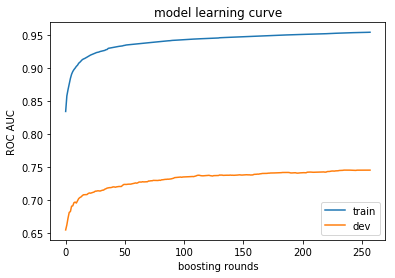

In [80]:
params = {
 'max_depth': 14,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'auc'],
 'eta': 0.2613422990687285,
 'min_child_weight': 2,
 'reg_alpha': 1.547978704593122,
 'reg_lambda': 1.6862550425820109,
 'scale_pos_weight': 3.5085580437807575,
 'subsample': 0.8603983319000923,
 'colsample_bylevel': 0.5745968600980427,
 'gamma': 1.2181926608051464e-07,
 'silent': 1,
}

evals_result = {}
booster = xgb.train(params, dtrain_limited, num_boost_round=2000, early_stopping_rounds=20, verbose_eval=True, evals=[(dtrain_limited, 'train'),(ddev, 'dev')], evals_result=evals_result)
plot_learning_curve(evals_result)

[0]	train-logloss:0.641056	train-auc:0.816934	dev-logloss:0.752552	dev-auc:0.633068
Multiple eval metrics have been passed: 'dev-auc' will be used for early stopping.

Will train until dev-auc hasn't improved in 20 rounds.
[1]	train-logloss:0.615589	train-auc:0.82963	dev-logloss:0.804412	dev-auc:0.638618
[2]	train-logloss:0.598513	train-auc:0.845924	dev-logloss:0.856764	dev-auc:0.644487
[3]	train-logloss:0.577545	train-auc:0.863679	dev-logloss:0.881955	dev-auc:0.652141
[4]	train-logloss:0.572036	train-auc:0.866838	dev-logloss:0.914622	dev-auc:0.659599
[5]	train-logloss:0.564061	train-auc:0.87075	dev-logloss:0.927677	dev-auc:0.66387
[6]	train-logloss:0.557621	train-auc:0.873916	dev-logloss:0.963846	dev-auc:0.66221
[7]	train-logloss:0.552846	train-auc:0.877479	dev-logloss:0.979267	dev-auc:0.667188
[8]	train-logloss:0.54803	train-auc:0.880856	dev-logloss:0.996301	dev-auc:0.665905
[9]	train-logloss:0.536779	train-auc:0.886741	dev-logloss:0.996043	dev-auc:0.680716
[10]	train-logloss:0.53457

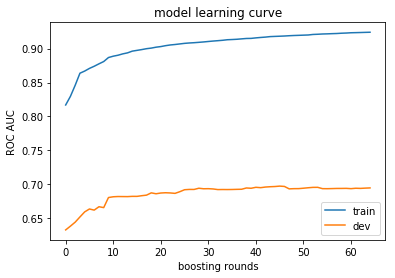

In [81]:
params = {
 'max_depth': 14,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'auc'],
 'eta': 0.2613422990687285,
 'min_child_weight': 2,
 'reg_alpha': 1.547978704593122,
 'reg_lambda': 1.6862550425820109,
 'scale_pos_weight': 3.5085580437807575,
 'subsample': 0.8603983319000923,
 'colsample_bylevel': 0.5745968600980427,
 'gamma': 1.2181926608051464e-07,
 'silent': 1,
}

evals_result = {}
booster = xgb.train(params, dtrain.slice(train[train.time >= datetime.datetime(2018, 1, 1)].index), num_boost_round=2000, early_stopping_rounds=20, verbose_eval=True, evals=[(dtrain.slice(train[train.time >= datetime.datetime(2018, 1, 1)].index), 'train'),(ddev, 'dev')], evals_result=evals_result)
plot_learning_curve(evals_result)

[0]	train-logloss:0.639017	train-auc:0.822306	dev-logloss:0.734101	dev-auc:0.604753
Multiple eval metrics have been passed: 'dev-auc' will be used for early stopping.

Will train until dev-auc hasn't improved in 20 rounds.
[1]	train-logloss:0.606158	train-auc:0.844255	dev-logloss:0.787576	dev-auc:0.600837
[2]	train-logloss:0.589022	train-auc:0.853479	dev-logloss:0.827446	dev-auc:0.624998
[3]	train-logloss:0.577214	train-auc:0.864343	dev-logloss:0.854551	dev-auc:0.641783
[4]	train-logloss:0.564873	train-auc:0.872653	dev-logloss:0.864406	dev-auc:0.659449
[5]	train-logloss:0.558813	train-auc:0.877143	dev-logloss:0.894171	dev-auc:0.65307
[6]	train-logloss:0.551133	train-auc:0.882373	dev-logloss:0.913651	dev-auc:0.646546
[7]	train-logloss:0.546362	train-auc:0.884682	dev-logloss:0.927897	dev-auc:0.64663
[8]	train-logloss:0.543168	train-auc:0.886562	dev-logloss:0.933539	dev-auc:0.651974
[9]	train-logloss:0.539774	train-auc:0.888493	dev-logloss:0.950506	dev-auc:0.651159
[10]	train-logloss:0.53

[96]	train-logloss:0.449554	train-auc:0.924774	dev-logloss:1.01579	dev-auc:0.698491
[97]	train-logloss:0.449038	train-auc:0.92493	dev-logloss:1.01614	dev-auc:0.698508
[98]	train-logloss:0.448706	train-auc:0.925047	dev-logloss:1.01593	dev-auc:0.698856
[99]	train-logloss:0.448305	train-auc:0.925167	dev-logloss:1.01554	dev-auc:0.699329
[100]	train-logloss:0.447504	train-auc:0.925405	dev-logloss:1.01569	dev-auc:0.699465
[101]	train-logloss:0.447144	train-auc:0.925505	dev-logloss:1.01515	dev-auc:0.699619
[102]	train-logloss:0.446799	train-auc:0.925648	dev-logloss:1.01486	dev-auc:0.69962
[103]	train-logloss:0.446462	train-auc:0.925808	dev-logloss:1.01429	dev-auc:0.699684
[104]	train-logloss:0.44595	train-auc:0.925933	dev-logloss:1.01913	dev-auc:0.698706
[105]	train-logloss:0.445605	train-auc:0.926065	dev-logloss:1.01863	dev-auc:0.699144
[106]	train-logloss:0.445322	train-auc:0.926161	dev-logloss:1.01815	dev-auc:0.699433
[107]	train-logloss:0.444852	train-auc:0.926289	dev-logloss:1.01795	dev-

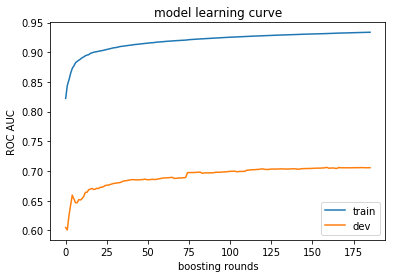

In [84]:
params = {
 'max_depth': 14,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'auc'],
 'eta': 0.2613422990687285,
 'min_child_weight': 2,
 'reg_alpha': 1.547978704593122,
 'reg_lambda': 1.6862550425820109,
 'scale_pos_weight': 3.5085580437807575,
 'subsample': 0.8603983319000923,
 'colsample_bylevel': 0.5745968600980427,
 'gamma': 1.2181926608051464e-07,
 'silent': 1,
}

evals_result = {}
booster = xgb.train(params, dtrain.slice(train[train.time >= datetime.datetime(2017, 11, 1)].index), num_boost_round=2000, early_stopping_rounds=20, verbose_eval=True, evals=[(dtrain.slice(train[train.time >= datetime.datetime(2017, 11, 1)].index), 'train'),(ddev, 'dev')], evals_result=evals_result)
plot_learning_curve(evals_result)

[0]	train-logloss:0.628353	train-auc:0.834221	dev-logloss:0.754313	dev-auc:0.654553
Multiple eval metrics have been passed: 'dev-auc' will be used for early stopping.

Will train until dev-auc hasn't improved in 20 rounds.
[1]	train-logloss:0.593368	train-auc:0.857809	dev-logloss:0.807723	dev-auc:0.662193
[2]	train-logloss:0.569879	train-auc:0.867392	dev-logloss:0.87013	dev-auc:0.672547
[3]	train-logloss:0.553341	train-auc:0.876023	dev-logloss:0.907666	dev-auc:0.681094
[4]	train-logloss:0.542173	train-auc:0.884273	dev-logloss:0.956412	dev-auc:0.682413
[5]	train-logloss:0.528922	train-auc:0.890663	dev-logloss:0.985533	dev-auc:0.690525
[6]	train-logloss:0.522744	train-auc:0.894779	dev-logloss:1.01496	dev-auc:0.691012
[7]	train-logloss:0.514549	train-auc:0.89771	dev-logloss:1.03526	dev-auc:0.695884
[8]	train-logloss:0.509746	train-auc:0.89995	dev-logloss:1.05469	dev-auc:0.696783
[9]	train-logloss:0.504555	train-auc:0.902567	dev-logloss:1.07796	dev-auc:0.695296
[10]	train-logloss:0.50083	t

[97]	train-logloss:0.386678	train-auc:0.942746	dev-logloss:1.13127	dev-auc:0.734728
[98]	train-logloss:0.386137	train-auc:0.942838	dev-logloss:1.14149	dev-auc:0.734406
[99]	train-logloss:0.385682	train-auc:0.942989	dev-logloss:1.14237	dev-auc:0.734835
[100]	train-logloss:0.385549	train-auc:0.943064	dev-logloss:1.14268	dev-auc:0.734883
[101]	train-logloss:0.385064	train-auc:0.943149	dev-logloss:1.1414	dev-auc:0.735011
[102]	train-logloss:0.384221	train-auc:0.94337	dev-logloss:1.13984	dev-auc:0.735009
[103]	train-logloss:0.383817	train-auc:0.943475	dev-logloss:1.13921	dev-auc:0.735031
[104]	train-logloss:0.383627	train-auc:0.943552	dev-logloss:1.1397	dev-auc:0.735235
[105]	train-logloss:0.383127	train-auc:0.943672	dev-logloss:1.13902	dev-auc:0.735352
[106]	train-logloss:0.382685	train-auc:0.943787	dev-logloss:1.13918	dev-auc:0.735496
[107]	train-logloss:0.382409	train-auc:0.943885	dev-logloss:1.1386	dev-auc:0.735534
[108]	train-logloss:0.382162	train-auc:0.943965	dev-logloss:1.13881	dev-

[195]	train-logloss:0.356598	train-auc:0.950718	dev-logloss:1.12791	dev-auc:0.740779
[196]	train-logloss:0.356491	train-auc:0.950791	dev-logloss:1.12884	dev-auc:0.740664
[197]	train-logloss:0.356272	train-auc:0.950862	dev-logloss:1.12857	dev-auc:0.740905
[198]	train-logloss:0.35601	train-auc:0.950912	dev-logloss:1.12769	dev-auc:0.741077
[199]	train-logloss:0.355848	train-auc:0.95099	dev-logloss:1.128	dev-auc:0.741192
[200]	train-logloss:0.355642	train-auc:0.951034	dev-logloss:1.12742	dev-auc:0.74118
[201]	train-logloss:0.355283	train-auc:0.951119	dev-logloss:1.12675	dev-auc:0.741372
[202]	train-logloss:0.355072	train-auc:0.951173	dev-logloss:1.12683	dev-auc:0.741249
[203]	train-logloss:0.354909	train-auc:0.951223	dev-logloss:1.12658	dev-auc:0.741245
[204]	train-logloss:0.35466	train-auc:0.951303	dev-logloss:1.1234	dev-auc:0.742092
[205]	train-logloss:0.354448	train-auc:0.951335	dev-logloss:1.12304	dev-auc:0.742232
[206]	train-logloss:0.354393	train-auc:0.95138	dev-logloss:1.12322	dev-a

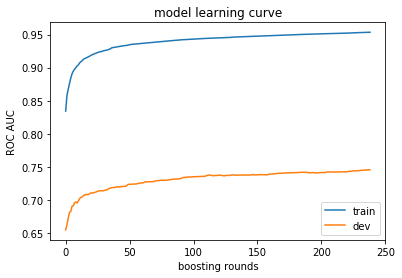

In [87]:
params = {
 'max_depth': 14,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'auc'],
 'eta': 0.2613422990687285,
 'min_child_weight': 2,
 'reg_alpha': 1.547978704593122,
 'reg_lambda': 1.6862550425820109,
 'scale_pos_weight': 3.5085580437807575,
 'subsample': 0.8603983319000923,
 'colsample_bylevel': 0.5745968600980427,
 'gamma': 1.2181926608051464e-07,
 'silent': 1,
}

evals_result = {}
booster = xgb.train(params, dtrain_limited, num_boost_round=239, early_stopping_rounds=20, verbose_eval=True, evals=[(dtrain_limited, 'train'),(ddev, 'dev')], evals_result=evals_result)
plot_learning_curve(evals_result)

[0]	train-logloss:0.623168	train-auc:0.844938	dev-logloss:0.747046	dev-auc:0.684268
Multiple eval metrics have been passed: 'dev-auc' will be used for early stopping.

Will train until dev-auc hasn't improved in 20 rounds.
[1]	train-logloss:0.582152	train-auc:0.865779	dev-logloss:0.795102	dev-auc:0.690435
[2]	train-logloss:0.55451	train-auc:0.881245	dev-logloss:0.836964	dev-auc:0.703671
[3]	train-logloss:0.539193	train-auc:0.889299	dev-logloss:0.886079	dev-auc:0.70338
[4]	train-logloss:0.523402	train-auc:0.894783	dev-logloss:0.915078	dev-auc:0.707233
[5]	train-logloss:0.515173	train-auc:0.899089	dev-logloss:0.954277	dev-auc:0.705715
[6]	train-logloss:0.503222	train-auc:0.904036	dev-logloss:0.986478	dev-auc:0.709566
[7]	train-logloss:0.497399	train-auc:0.905788	dev-logloss:0.998759	dev-auc:0.711453
[8]	train-logloss:0.492383	train-auc:0.907925	dev-logloss:1.02384	dev-auc:0.711191
[9]	train-logloss:0.487201	train-auc:0.910443	dev-logloss:1.04141	dev-auc:0.712305
[10]	train-logloss:0.4852

[97]	train-logloss:0.376579	train-auc:0.945949	dev-logloss:1.13318	dev-auc:0.73957
[98]	train-logloss:0.376198	train-auc:0.946047	dev-logloss:1.13459	dev-auc:0.740092
[99]	train-logloss:0.375365	train-auc:0.946205	dev-logloss:1.134	dev-auc:0.740862
[100]	train-logloss:0.374934	train-auc:0.946327	dev-logloss:1.13343	dev-auc:0.741003
[101]	train-logloss:0.374527	train-auc:0.946407	dev-logloss:1.13321	dev-auc:0.741119
[102]	train-logloss:0.37382	train-auc:0.946579	dev-logloss:1.13256	dev-auc:0.741282
[103]	train-logloss:0.372656	train-auc:0.946815	dev-logloss:1.13044	dev-auc:0.741704
[104]	train-logloss:0.37241	train-auc:0.946916	dev-logloss:1.13011	dev-auc:0.74212
[105]	train-logloss:0.372086	train-auc:0.947008	dev-logloss:1.12933	dev-auc:0.742586
[106]	train-logloss:0.371777	train-auc:0.947107	dev-logloss:1.12964	dev-auc:0.742204
[107]	train-logloss:0.371561	train-auc:0.947188	dev-logloss:1.12598	dev-auc:0.742977
[108]	train-logloss:0.371315	train-auc:0.947263	dev-logloss:1.12606	dev-au

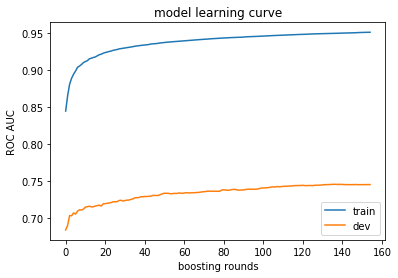

In [46]:
params = {
 'max_depth': 14,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'auc'],
 'eta': 0.2613422990687285,
 'min_child_weight': 2,
 'reg_alpha': 1.547978704593122,
 'reg_lambda': 1.6862550425820109,
 'scale_pos_weight': 3.5085580437807575,
 'subsample': 0.8603983319000923,
 'colsample_bylevel': 0.5745968600980427,
 'gamma': 1.2181926608051464e-07,
 'silent': 1,
}

evals_result = {}
booster = xgb.train(params, dtrain_limited, num_boost_round=239, early_stopping_rounds=20, verbose_eval=True, evals=[(dtrain_limited, 'train'),(ddev, 'dev')], evals_result=evals_result)
plot_learning_curve(evals_result)

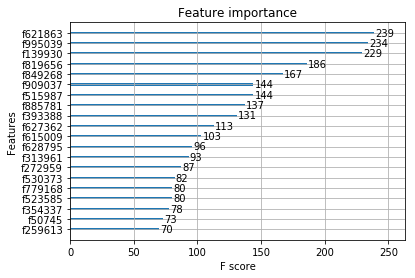

In [47]:
xgb.plot_importance(booster, max_num_features=20)

In [89]:
preds = booster.predict(dtest)

In [90]:
roc_auc_score(y_test, preds)

0.7353651879545815

In [ ]:
params = {
 'base_score': y_train.mean(),
 'max_depth': 3,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'auc'],
 'eta': .1,
 'silent': 1,
 'reg_lambda': 2
}

evals_result = {}
booster = xgb.train(params, dtrain, num_boost_round=2000, early_stopping_rounds=20, verbose_eval=True, evals=[(dtrain, 'train'),(ddev, 'dev')], evals_result=evals_result)
plot_learning_curve(evals_result)

In [67]:
preds = booster.predict(dtest, ntree_limit=booster.best_ntree_limit)
roc_auc_score(dtest.get_label(), preds)

0.7058104080004659

In [68]:
recent_test = pq.ParquetDataset('marvel-recent/').read().to_pandas()

exoc_recent = exoctet(recent_test)

y_recent = recent_test.pop('target').astype(np.bool)

hashed_recent = hasher.transform(get_features(recent_test, features))

drecent = xgb.DMatrix(hstack((hashed_recent, exoc_recent)), y_recent)

preds_recent = booster.predict(drecent)
roc_auc_score(drecent.get_label(), preds_recent)

0.5824789867508353

In [69]:
aucs = []
days = []
for day in np.sort(recent_test.day.unique()):
    days.append(day)
    indices = recent_test[recent_test.day == day].index
    sliced = drecent.slice(indices)
    day_preds = booster.predict(sliced, ntree_limit=booster.best_ntree_limit)
    aucs.append(roc_auc_score(sliced.get_label(), day_preds))
    
plt.plot(days, aucs)
plt.title('ROC AUC by day May')
plt.ylabel('ROC AUC')
plt.xlabel('Day')
plt.xticks(days)
plt.show()

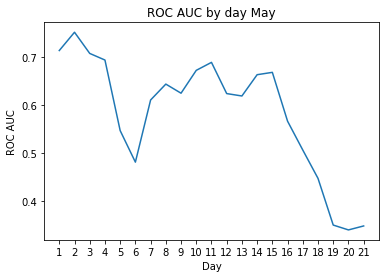

In [70]:
plt.plot(days, aucs)
plt.title('ROC AUC by day May')
plt.ylabel('ROC AUC')
plt.xlabel('Day')
plt.xticks(days)
plt.show()

In [74]:
recent_test['conversion'] = y_recent

In [ ]:
conversions = []
days = []
for day in np.sort(recent_test.day.unique()):
    days.append(day)
    day_data = recent_test[recent_test.day == day]    
    conversions.append()

In [ ]:
plt.plot(days, aucs)
plt.title('Conversions by day May')
plt.ylabel('Conversion count')
plt.xlabel('Day')
plt.xticks(days)
plt.show()

In [79]:
recent_test = pq.ParquetDataset('marvel-recent/').read().to_pandas()

exoc_recent = exoctet(recent_test)

y_recent = recent_test.pop('target').astype(np.bool)

hashed_recent = hasher.transform(get_features(recent_test, features))

drecent = xgb.DMatrix(hstack((hashed_recent, exoc_recent)), y_recent)

preds_recent = booster.predict(drecent)
roc_auc_score(drecent.get_label(), preds_recent)

0.6639887853306816

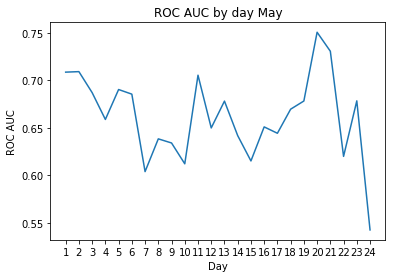

In [80]:
aucs = []
days = []
for day in np.sort(recent_test.day.unique()):
    days.append(day)
    indices = recent_test[recent_test.day == day].index
    sliced = drecent.slice(indices)
    day_preds = booster.predict(sliced, ntree_limit=booster.best_ntree_limit)
    aucs.append(roc_auc_score(sliced.get_label(), day_preds))
    
plt.plot(days, aucs)
plt.title('ROC AUC by day May')
plt.ylabel('ROC AUC')
plt.xlabel('Day')
plt.xticks(days)
plt.show()

In [88]:
recent_test['predictions'] = preds_recent

In [89]:
recent = recent_test

In [90]:
recent['predictions'].describe(percentiles=[.25, .85])

count    1.400547e+06
mean     2.510212e-01
std      1.314512e-01
min      1.509187e-02
25%      1.493303e-01
50%      2.137348e-01
85%      3.768540e-01
max      8.753839e-01
Name: predictions, dtype: float64

In [91]:
recent['conversion'] = y_recent

In [92]:
recent['impression'] = 1

In [93]:
percentiles = np.percentile(recent.predictions, np.arange(5, 100, 5), interpolation='nearest')

In [ ]:
# impressions, conversions, revenue from .05 to .95

In [94]:
list(zip(np.arange(5, 100, 5), percentiles))

[(5, 0.07657927),
 (10, 0.10702784),
 (15, 0.13058539),
 (20, 0.140806),
 (25, 0.14933033),
 (30, 0.16785409),
 (35, 0.18574528),
 (40, 0.19991904),
 (45, 0.20465095),
 (50, 0.21373478),
 (55, 0.24659722),
 (60, 0.2653443),
 (65, 0.29855773),
 (70, 0.30972418),
 (75, 0.30972418),
 (80, 0.3461201),
 (85, 0.376854),
 (90, 0.43669215),
 (95, 0.48157296)]

In [95]:
low = percentiles[0]
datas = [(recent[recent.predictions < low], f'< {low}')]
for percentile in percentiles[1:-1]:
    data = recent[(recent.predictions >= low) & (recent.predictions < percentile)]
    datas.append((data, f'>= {low} and < {percentile}'))
    low = percentile
    
datas.append((recent[recent.predictions >= percentiles[-1]], f'>= {percentile}'))

In [96]:
len(datas)

19

In [97]:
len(percentiles)

19

In [98]:
groups = []
for data, cutoff in datas:
    df_data = dict(data.agg({'impression': 'count', 'conversion': 'sum', 'bid_amount': 'sum'}))
    df_data['cutoff'] = cutoff
    groups.append(df_data)

In [99]:
cutoff_data = pd.DataFrame(groups)

In [100]:
cutoff_data

,bid_amount,conversion,cutoff,impression
0,137.763783,32.0,< 0.0765792727470398,67278.0
1,186.632335,131.0,>= 0.0765792727470398 and < 0.10702784359455109,72740.0
2,275.919926,87.0,>= 0.10702784359455109 and < 0.13058538734912872,66417.0
3,80.287238,381.0,>= 0.13058538734912872 and < 0.14080600440502167,46465.0
4,486.225854,141.0,>= 0.14080600440502167 and < 0.14933033287525177,79813.0
5,218.349302,96.0,>= 0.14933033287525177 and < 0.16785408556461334,84839.0
6,305.113244,114.0,>= 0.16785408556461334 and < 0.18574528396129608,53346.0
7,131.631564,118.0,>= 0.18574528396129608 and < 0.19991904497146606,56599.0
8,501.763432,218.0,>= 0.19991904497146606 and < 0.20465095341205597,97209.0
9,434.142253,580.0,>= 0.20465095341205597 and < 0.21373477578163147,75565.0


In [114]:
save_xjs_model(booster, 'classifier', 'conversion-boost-2018-05-24.xjs', base_score=y_train.mean())

In [115]:
booster.save_model('conversion-boost-2018-05-24.bin')

# Checking internal sources

In [ ]:
recent_test

In [102]:
source_conv_rate = recent_test.groupby('source_id')['conversion'].sum() / recent_test.groupby('source_id')['conversion'].count()

In [103]:
source_conv_rate.sort_values(ascending=False)

source_id
380    0.142857
40     0.053571
64     0.041401
178    0.030075
381    0.023810
309    0.020038
341    0.016091
351    0.014742
270    0.014423
131    0.011720
58     0.011521
212    0.011038
357    0.010707
355    0.010101
7      0.008991
151    0.008985
302    0.008889
298    0.007267
282    0.007036
88     0.006592
305    0.006544
94     0.006250
370    0.005972
28     0.005967
150    0.005726
249    0.005245
109    0.005047
93     0.004559
4      0.004320
337    0.003914
         ...   
227    0.000000
99     0.000000
272    0.000000
285    0.000000
68     0.000000
65     0.000000
60     0.000000
57     0.000000
56     0.000000
55     0.000000
54     0.000000
375    0.000000
374    0.000000
373    0.000000
363    0.000000
36     0.000000
358    0.000000
356    0.000000
354    0.000000
352    0.000000
338    0.000000
335    0.000000
332    0.000000
33     0.000000
323    0.000000
312    0.000000
304    0.000000
301    0.000000
292    0.000000
311    0.000000
Name: conversi

In [104]:
source_conv_rate[source_conv_rate.index == '1']

source_id
1    0.002841
Name: conversion, dtype: float64

In [105]:
source_conv_rate[source_conv_rate.index == '8']

source_id
8    0.001506
Name: conversion, dtype: float64

In [123]:
code_preform = recent_test[recent_test.subid == '2606']

In [124]:
code_preform['conversion'].sum() / code_preform['conversion'].count()

0.0014929331969231936

In [108]:
train['conversion'] = dtrain.get_label().astype(np.bool)

In [109]:
source_conv_rate_train = train.groupby('source_id')['conversion'].sum() / train.groupby('source_id')['conversion'].count()

In [110]:
source_conv_rate_train.sort_values(ascending=False)

source_id
26     0.808092
185    0.748165
180    0.739946
270    0.721012
18     0.697635
131    0.696721
150    0.685641
64     0.685347
31     0.644967
341    0.611504
88     0.600583
94     0.558239
28     0.519582
36     0.503198
279    0.479125
345    0.468750
68     0.434051
298    0.433743
55     0.427807
15     0.425059
246    0.420998
245    0.413808
173    0.400870
4      0.386674
144    0.380550
54     0.370988
234    0.349743
145    0.348761
151    0.348718
277    0.348024
         ...   
136    0.087951
303    0.081463
105    0.080247
7      0.073171
243    0.072726
29     0.068458
282    0.061962
302    0.061741
123    0.052574
193    0.051282
305    0.049296
65     0.036036
165    0.032520
322    0.031963
308    0.031662
184    0.030916
158    0.029851
295    0.026667
87     0.025641
255    0.016484
280    0.016129
312    0.015748
60     0.012706
227    0.010870
323    0.010018
310    0.004032
297    0.000000
139    0.000000
284    0.000000
218    0.000000
Name: conversi

In [111]:
code_preform_train = train[train.subid == '2606']

In [112]:
code_preform_train['conversion'].sum() / code_preform_train['conversion'].count()

0.1808635319488069

In [113]:
source_conv_rate_train.sort_values(ascending=False)

source_id
26     0.808092
185    0.748165
180    0.739946
270    0.721012
18     0.697635
131    0.696721
150    0.685641
64     0.685347
31     0.644967
341    0.611504
88     0.600583
94     0.558239
28     0.519582
36     0.503198
279    0.479125
345    0.468750
68     0.434051
298    0.433743
55     0.427807
15     0.425059
246    0.420998
245    0.413808
173    0.400870
4      0.386674
144    0.380550
54     0.370988
234    0.349743
145    0.348761
151    0.348718
277    0.348024
         ...   
136    0.087951
303    0.081463
105    0.080247
7      0.073171
243    0.072726
29     0.068458
282    0.061962
302    0.061741
123    0.052574
193    0.051282
305    0.049296
65     0.036036
165    0.032520
322    0.031963
308    0.031662
184    0.030916
158    0.029851
295    0.026667
87     0.025641
255    0.016484
280    0.016129
312    0.015748
60     0.012706
227    0.010870
323    0.010018
310    0.004032
297    0.000000
139    0.000000
284    0.000000
218    0.000000
Name: conversi

In [116]:
len(code_preform[code_preform.predictions < 0.1305853873]) / len(code_preform)

0.13437914440528967

In [117]:
len(code_preform[code_preform.predictions >= 0.31]) / len(code_preform)

0.036595809177371076

In [ ]:
bundlore pops - 2267 , 2484

In [119]:
bundlore = recent_test[(recent_test.subid == '2267') | (recent_test.subid == '2484')]

In [120]:
len(bundlore)

185083

In [121]:
len(bundlore[bundlore.predictions < 0.1305853873]) / len(bundlore)

0.052943814396784146

In [122]:
len(bundlore[bundlore.predictions >= 0.31]) / len(bundlore)

0.331121712961212